In [105]:
import math

import numpy as np
from tqdm import tqdm

## Data generation with showerpipe

In [2]:
import showerpipe as shp

- showerpipe wraps pythia8's generator in a standard Python iterator
- Need to pass a settings file during initialisation, see below:

In [3]:
%%file pythia-settings.cmnd
Beams:idB = -2212
Beams:eCM = 1960.
WeakSingleBoson:ffbar2gmZ = on
PhaseSpace:mHatMin = 80.
PhaseSpace:mHatMax = 120

Overwriting pythia-settings.cmnd


In [4]:
gen = shp.generator.PythiaGenerator("pythia-settings.cmnd")
gen

PythiaGenerator(xml_dir='/scratch/jlc1n20/mambaforge/envs/dgl/share/Pythia8/xmldoc')
├── Print
│   └── quiet = on
├── Random
│   ├── setSeed = on
│   └── seed = -1
├── Beams
│   ├── idB = -2212
│   └── eCM = 1960.
├── WeakSingleBoson
│   └── ffbar2gmZ = on
└── PhaseSpace
    ├── mHatMin = 80.
    └── mHatMax = 120

- `PythiaGenerator`
    - repr and string shows settings and location of Pythia8's XML data directory
    - Events generated simply by looping over `gen`, or calling `next()`
- `PythiaEvent`
    - repr shows underlying pythia8 instance, string shows number of particles
    - Properties, *eg.* `.pdg`, `.pmu` (momentum), `.edges`, expose record via numpy arrays

Comprehensive documentation can be seen by either calling `help(event)`, or checking the [API reference online](https://showerpipe.readthedocs.io/en/latest/api/showerpipe.generator.PythiaEvent.html).

In [5]:
event = next(gen)

print(repr(event))
print(event)

PythiaEvent(_event=<pythia8.Event object at 0x2b8dd64aab30>)
PythiaEvent(len=300)


- Some arrays are structured, such as `.pmu`, `.color`, and `.edges`

In [6]:
event.pmu[:5]  # momenta of the first 8 particles

array([(0., 0.,  979.99955084, 980.        ),
       (0., 0., -979.99955084, 980.        ),
       (0., 0.,  121.88537547, 121.88537547),
       (0., 0.,  -18.0319325 ,  18.0319325 ),
       (0., 0.,  103.85344298, 139.91730797)],
      dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('e', '<f8')])

In [7]:
event.pdg[:5]  # pdg codes of the first 8 particles

array([ 2212, -2212,     1,    -1,    23], dtype=int32)

- Length of these iterators is endless, calling `len()` results in a `NotImplementedError`
- LHE files can be used to generate data from hard processes stored on disk
- `PythiaGenerator` then has length equal to number of events in LHE file
- Example shown in next section about `graphicle`

## Manipulating the event record with graphicle

In [8]:
import graphicle as gcl

- **graphicle** is a portmanteau of "graph" and "particle"
- Thin wrappers around the array data add semantic meaning and functionality
- These data structures include `MomentumArray`, `PdgArray`, `AdjacencyList`, *etc.*

New `PythiaGenerator` instantiated with LHE file and relevant new settings:

In [9]:
%%file pythia-settings.cmnd
PartonLevel:ISR = on
PartonLevel:FSR = on
PartonLevel:MPI = on
HadronLevel:all = on
Beams:frameType = 4

Overwriting pythia-settings.cmnd


In [177]:
gen = shp.generator.PythiaGenerator(
    "pythia-settings.cmnd",
    lhe_file="gb_tw_10k.lhe.gz",
    rng_seed=10,
)
event = next(gen)

 *-----------------------  SusyLesHouches SUSY/BSM Interface  ------------------------*
 | Last Change 12 Apr 2017 - P. Skands
 | Parsing: /tmp/tmpd9ju2u2i
 | (SLHA::readFile) line 361 - storing non-SLHA(2) block: yukawa
 *------------------------------------------------------------------------------------*


In [178]:
pmu = gcl.MomentumArray(event.pmu)
pmu

MomentumArray([[ 0.00000000e+00  0.00000000e+00  6.49999993e+03  6.50000000e+03]
               [ 0.00000000e+00  0.00000000e+00 -6.49999993e+03  6.50000000e+03]
               [-0.00000000e+00  0.00000000e+00  1.28773249e+02  1.28773249e+02]
               ...
               [-8.74716207e-02  1.69443178e+00  1.06808811e+01  1.08157039e+01]
               [-8.19014141e-01 -2.34581957e+00 -3.31415578e-01  2.51057159e+00]
               [-4.19819174e-02 -1.53076941e+00  2.80497708e-02  1.53794799e+00]],
              dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('e', '<f8')])

In [179]:
pmu.mass[:10]

array([ 9.38269999e-01,  9.38269999e-01,  0.00000000e+00,  0.00000000e+00,
        8.19758520e+01,  1.73212374e+02,  7.45793091e-06, -3.30618453e-06,
        8.19758520e+01,  1.73212374e+02])

In [180]:
pmu_rotate = pmu.shift_phi(0.5 * 3.14)
pmu_rotate

MomentumArray([[ 0.00000000e+00  0.00000000e+00  6.49999993e+03  6.50000000e+03]
               [ 0.00000000e+00  0.00000000e+00 -6.49999993e+03  6.50000000e+03]
               [-0.00000000e+00  0.00000000e+00  1.28773249e+02  1.28773249e+02]
               ...
               [-1.69450090e+00 -8.61222717e-02  1.06808811e+01  1.08157039e+01]
               [ 2.34516663e+00 -8.20881920e-01 -3.31415578e-01  2.51057159e+00]
               [ 1.53073549e+00 -4.32008967e-02  2.80497708e-02  1.53794799e+00]],
              dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('e', '<f8')])

In [181]:
pdgs = gcl.PdgArray(event.pdg)
names = pdgs.name
charges = pdgs.charge
print(pdgs[:6])
print(f"name: {names[:6]}")
print(f"charge: {charges[:6]}")

PdgArray([2212 2212    5   21  -24    6], dtype=int32)
name: ['p' 'p' 'b' 'g' 'W-' 't']
charge: [ 1.          1.         -0.33333333  0.         -1.          0.66666667]


In [182]:
adj = gcl.AdjacencyList(event.edges)
adj

AdjacencyList([[   0   -1]
               [   0   -2]
               [  -6   -3]
               ...
               [-554  561]
               [-559  562]
               [-559  563]],
              dtype=[('src', '<i4'), ('dst', '<i4')])

In [183]:
print(np.array_equal(adj.leaves, event.final))

True


### Composite data structures

- graphicle's types used to form composite data structures
- Enables the ability to subscript over the full event
- Methods and routines in modules combine and cross reference data record

### Instantiating

- There are two\* composite data structures for the event record:
  1. `ParticleSet`
  2. `Graphicle` (which contains `ParticleSet` and `AdjacencyList`).
- Can be instantiated by passing:
  * numpy arrays for each attribute
  * existing constituent objects
  * an object which has the same interface as `PythiaEvent`.

\*There is also a composite structure called `MaskGroup`, which will be discussed in the section about querying the event.

In [184]:
graph = gcl.Graphicle.from_event(event)
graph

name,px,py,pz,energy,color,anticolor,helicity,status,final,src,dst
p,0.00E+00,0.00E+00,6.50E+03,6.50E+03,0,0,9,-12,False,0,-1
p,0.00E+00,0.00E+00,-6.50E+03,6.50E+03,0,0,9,-12,False,0,-2
b,-0.00E+00,0.00E+00,1.29E+02,1.29E+02,503,0,-1,-21,False,-6,-3
g,0.00E+00,-0.00E+00,-1.92E+02,1.92E+02,502,503,-1,-21,False,-7,-3
W-,3.23E+01,1.76E+01,5.74E+01,1.07E+02,0,0,0,-22,False,-3,-4
...,...,...,...,...,...,...,...,...,...,...,...
rho(770)0,-8.61E-01,-3.88E+00,-3.03E-01,4.05E+00,0,0,9,-91,False,-549,-559
K+,1.32E-01,3.52E+00,2.30E+01,2.33E+01,0,0,9,91,True,-554,560
pi-,-8.75E-02,1.69E+00,1.07E+01,1.08E+01,0,0,9,91,True,-554,561
pi+,-8.19E-01,-2.35E+00,-3.31E-01,2.51E+00,0,0,9,91,True,-559,562


### Querying the event record

- Possible to form complex filters over the whole event record

A simple start is to use the `.hard_mask` attribute (actually aliased from `StatusArray.hard_mask`), which gives a boolean mask identifying the hard process.

In [185]:
graph[graph.hard_mask]

name,px,py,pz,energy,color,anticolor,helicity,status,final,src,dst
b,-0.00E+00,0.00E+00,1.29E+02,1.29E+02,503,0,-1,-21,False,-6,-3
g,0.00E+00,-0.00E+00,-1.92E+02,1.92E+02,502,503,-1,-21,False,-7,-3
W-,3.23E+01,1.76E+01,5.74E+01,1.07E+02,0,0,0,-22,False,-3,-4
t,-3.23E+01,-1.76E+01,-1.21E+02,2.14E+02,502,0,0,-22,False,-3,-5
e-,5.05E+01,1.78E+01,2.71E+01,6.00E+01,0,0,-1,23,True,-98,128
nu(e)~,-2.27E+01,-2.04E+01,3.57E+01,4.70E+01,0,0,1,23,True,-98,129
W+,-1.00E+01,4.89E+01,-5.59E+01,1.05E+02,0,0,0,-22,False,-99,-130
b,-1.40E+01,-8.97E+01,-6.39E+01,1.11E+02,502,0,-1,-23,False,-99,-131
u,-4.16E+01,2.86E+01,-3.39E+01,6.08E+01,501,0,-1,-23,False,-134,-161
d~,3.18E+01,1.49E+01,-2.04E+01,4.07E+01,0,501,1,-23,False,-134,-162


- `.hard_mask` attribute is a `MaskGroup`
- Enables labelling and organising masks in hierarchies
- `.hard_mask` is a flat `MaskGroup`, identifying different sections of the hard process
- Nesting structure of `MaskGroup` instances seen by printing

In [186]:
print(graph.hard_mask)

MaskGroup(agg_op=OR)
├── incoming
├── intermediate
├── outgoing
└── outgoing_nonperturbative_diffraction



- `MaskGroup` can be subscripted using strings...

In [187]:
graph[graph.hard_mask["outgoing"]]

name,px,py,pz,energy,color,anticolor,helicity,status,final,src,dst
e-,5.05E+01,1.78E+01,2.71E+01,6.00E+01,0,0,-1,23,True,-98,128
nu(e)~,-2.27E+01,-2.04E+01,3.57E+01,4.70E+01,0,0,1,23,True,-98,129
b,-1.40E+01,-8.97E+01,-6.39E+01,1.11E+02,502,0,-1,-23,False,-99,-131
u,-4.16E+01,2.86E+01,-3.39E+01,6.08E+01,501,0,-1,-23,False,-134,-161
d~,3.18E+01,1.49E+01,-2.04E+01,4.07E+01,0,501,1,-23,False,-134,-162


- ... or lists to form subsets of the original `MaskGroup`

In [188]:
sub_mask = graph.hard_mask[["outgoing", "intermediate"]]
print(sub_mask)
graph[sub_mask]

MaskGroup(agg_op=OR)
├── outgoing
└── intermediate



name,px,py,pz,energy,color,anticolor,helicity,status,final,src,dst
W-,3.23E+01,1.76E+01,5.74E+01,1.07E+02,0,0,0,-22,False,-3,-4
t,-3.23E+01,-1.76E+01,-1.21E+02,2.14E+02,502,0,0,-22,False,-3,-5
e-,5.05E+01,1.78E+01,2.71E+01,6.00E+01,0,0,-1,23,True,-98,128
nu(e)~,-2.27E+01,-2.04E+01,3.57E+01,4.70E+01,0,0,1,23,True,-98,129
W+,-1.00E+01,4.89E+01,-5.59E+01,1.05E+02,0,0,0,-22,False,-99,-130
b,-1.40E+01,-8.97E+01,-6.39E+01,1.11E+02,502,0,-1,-23,False,-99,-131
u,-4.16E+01,2.86E+01,-3.39E+01,6.08E+01,501,0,-1,-23,False,-134,-161
d~,3.18E+01,1.49E+01,-2.04E+01,4.07E+01,0,501,1,-23,False,-134,-162


- Nesting `MaskGroup`s is very useful for descendant hierarchy of hard process
- Routines in the `graphicle.select` module form more complex masks over the event record
- *eg.* `hierarchy()` traverses DAG to find descendants of partons in the hard process

In [189]:
hier = gcl.select.hierarchy(graph)
print(hier)

MaskGroup(agg_op=OR)
├── W-
│   ├── e-
│   ├── nu(e)~
│   └── latent
└── t
    ├── W+
    │   ├── u
    │   ├── d~
    │   └── latent
    ├── b
    └── latent



In [190]:
electron_final = hier["W-"]["e-"] & graph.final
electron_pmu = graph.pmu[electron_final]
print(f"Number of electron descendants in final state: {len(electron_pmu)}")
graph[electron_final]

Number of electron descendants in final state: 1


name,px,py,pz,energy,color,anticolor,helicity,status,final,src,dst
e-,5.05E+01,1.78E+01,2.71E+01,6.00E+01,0,0,-1,23,True,-98,128


- graphicle's wrappers are transparent to numpy
- simple functions, such as a sum, can be applied with ease
- Masking over descendants of a parton in final state, then summing, gives momentum reconstruction

In [191]:
electron_pmu_agg = np.sum(electron_pmu, axis=0)
print(electron_pmu_agg)

MomentumArray([[50.5088914  17.77404304 27.07457927 60.00081299]], dtype=[('x', '<f8'), ('y', '<f8'), ('z', '<f8'), ('e', '<f8')])


In [192]:
print(electron_pmu_agg.mass)

[0.000511]


In [193]:
hard_electron_mask = graph.hard_mask & (graph.pdg.name == "e-")
graph[hard_electron_mask]

name,px,py,pz,energy,color,anticolor,helicity,status,final,src,dst
e-,5.05E+01,1.78E+01,2.71E+01,6.00E+01,0,0,-1,23,True,-98,128


In [194]:
graph[hard_electron_mask].pmu.mass

array([0.000511])

- Reconstructed mass can be checked against the reference value from PDG record

In [195]:
graph.pdg[hard_electron_mask].mass

array([0.000511])

- Up one level of nesting in the `MaskGroup`, reconstruct the parent parton, `W+`:

In [196]:
W_plus_final = hier["W-"] & graph.final
W_plus_pmu = graph.pmu[W_plus_final]
np.sum(W_plus_pmu, axis=0).mass

array([81.97585196])

## Colliderscope

In [197]:
import colliderscope as csp

- With colliderscope, you can view the event record as a network, using `shower_dag()`

In [198]:
csp.shower_dag(
    output="generation-dag.html",
    edges=graph.adj,
    pdgs=graph.pdg,
    masks=hier.flatten("leaves"),
    notebook=True,
)

- It is also possible to view the final state particles on an interactive scatter plot, using `eta_phi_scatter()`

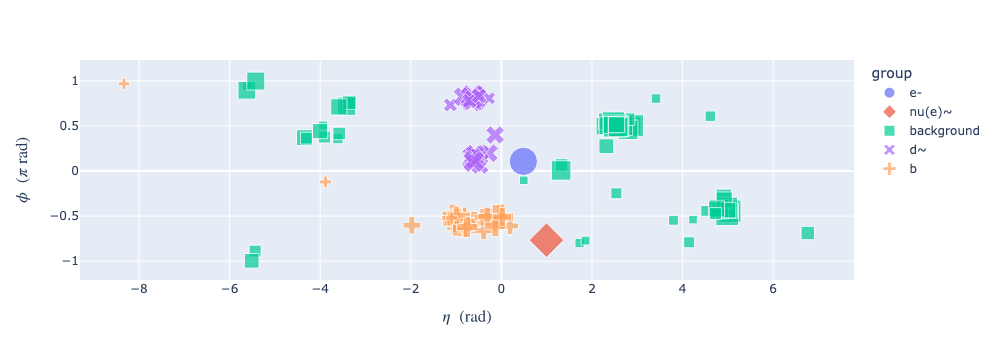

In [199]:
leaf_masks = hier.flatten("leaves")  # extract most nested masks
final_graph = graph[graph.final]  # mask over full event to final state
fig = csp.eta_phi_scatter(
    pmu=final_graph.pmu,
    pdg=final_graph.pdg,
    masks=leaf_masks[graph.final],
    pt_min=0.5,  # don't display transverse momentum < 0.5 GeV
)
fig.show()

- This purely topological cluster reconstruction picks up background
- Can use `graphicle.select.clusters()` to remove background based on momentum alignment and colour
  * Mass reconstructions are empirically found to be greatly improved with this!
  * `radius` here is *not* like anti-kt radius; clusters are purely reconstructed from Monte-Carlo truth

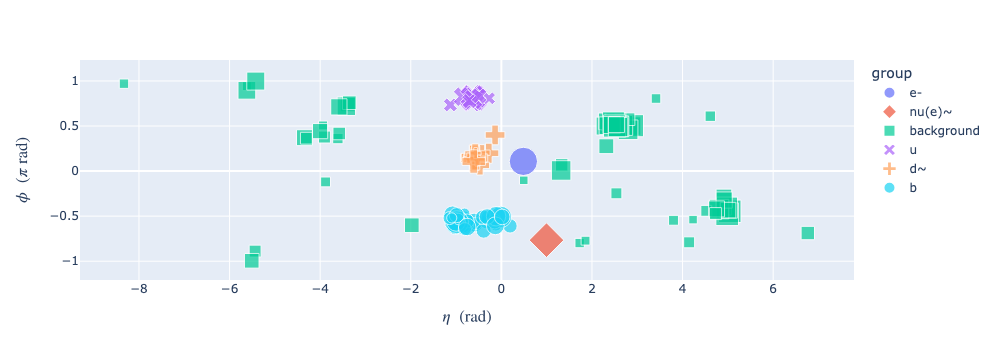

In [200]:
clusters = gcl.select.clusters(graph, radius=1.0)
fig = csp.eta_phi_scatter(
    pmu=final_graph.pmu,
    pdg=final_graph.pdg,
    masks=clusters,
    pt_min=0.5,
)
fig.show()

In [201]:
tbar_constit_pmu = final_graph.pmu[clusters["t"]]
tbar_recon_pmu = np.sum(tbar_constit_pmu, axis=0)
tbar_recon_pmu.mass

array([172.86560878])

- Constant memory histogramming functionality is available through `Hisogram`, and various functions

In [202]:
hist = csp.Histogram(num_bins=100, window=(150, 190))
for event in tqdm(gen):
    graph = gcl.Graphicle.from_event(event)
    clusters = gcl.select.clusters(graph, radius=1.0)
    # access the top mask, regardless if anti-particle or not
    t_mask = clusters.get("t", None)
    if t_mask is None:
        t_mask = clusters["t~"]
    final_graph = graph[graph.final]
    t_constit_pmu = final_graph.pmu[t_mask]
    t_recon_pmu = np.sum(t_constit_pmu, axis=0)
    mass = t_recon_pmu.mass.item()
    hist.update(mass)

100%|██████████████████████████████████████████████████████████▉| 9999/10000 [06:55<00:00, 24.06it/s]


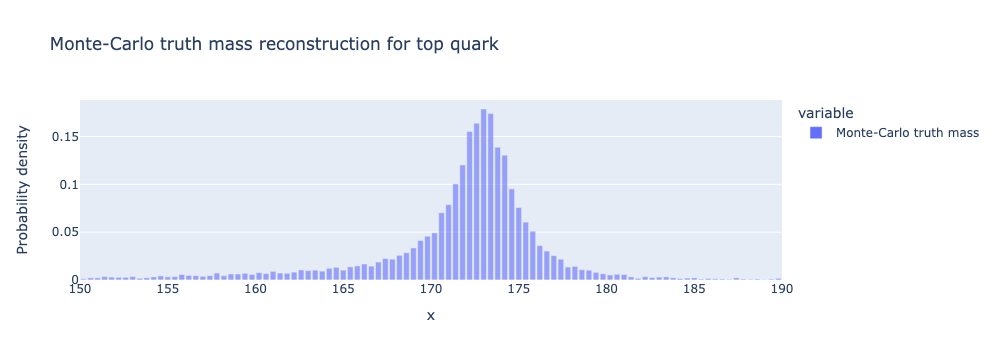

In [208]:
csp.histogram_barchart(
    hist,
    hist_label="Monte-Carlo truth mass",
    title="Monte-Carlo truth mass reconstruction for top quark",
)

In [209]:
csp.hist_to_bw_params(hist)

(172.8221146036791, 3.305779212063656)